In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Install the required packages (if not already installed)
!pip install opencv-python pycocotools matplotlib onnxruntime onnx ipykernel

In [ ]:
#clone github rep

import os

# Define the base directory path where you want to clone the repository
base_dir = '/content/gdrive/MyDrive/ArchComp/Grounded-Segment-Anything'  # Adjust the path as needed
# Create the directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Change the current working directory to the base directory
os.chdir(base_dir)

# Clone the repository if it doesn't exist
repo_name = "Grounded-Segment-Anything"
if not os.path.exists(repo_name):
    !git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git {repo_name}
else:
    print(f"{repo_name} repository already exists.")

# Verify that the repository is present
repo_path = os.path.join(base_dir, repo_name)
if not os.listdir(repo_path):
    print(f"Cloning failed, {repo_name} directory is empty.")
else:
    print(f"Repository cloned successfully: {os.listdir(repo_path)}")

# Change to the repository directory
os.chdir(repo_path)


In [ ]:
#download models
# Check if the repository directory already exists
repo_path = os.path.join(base_dir, 'Grounded-Segment-Anything')

# Define model file URLs and their expected paths
model_files = {
    "sam_vit_h_4b8939.pth": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "groundingdino_swint_ogc.pth": "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
}

# Download each model file if it doesn't already exist
for model_name, model_url in model_files.items():
    model_path = os.path.join(repo_path, model_name)
    if not os.path.isfile(model_path):
        !wget {model_url} -O {model_path}
    else:
        print(f"Model file {model_name} already exists.")


In [ ]:
# Install system dependencies for mmcv-full if needed
#!apt update
#!apt install -y ffmpeg libsm6 libxext6

# Try to install a binary version of mmcv-full that doesn't require building from source
#!pip install mmcv-full==1.3.17 --no-cache-dir --force-reinstall

# Install the conflicting packages as reported by the error
!pip install fastapi kaleido python-multipart uvicorn setuptools requests yfinance --upgrade

# Now, let's try installing the repositories again
%cd /content/gdrive/MyDrive/ArchComp/Grounded-Segment-Anything/Grounded-Segment-Anything
!python -m pip install -e segment_anything
!python -m pip install -e GroundingDINO

# If tokenizers is still failing to build, you may need to install it separately
!pip install tokenizers --no-cache-dir --force-reinstall


In [ ]:
# Install diffusers with torch extension
!pip install --upgrade diffusers[torch]

# Initialize and update submodules
!git submodule update --init --recursive

# Install RAM & Tag2Text dependencies
if os.path.isdir('Tag2Text'):
    %cd Tag2Text
    !pip install -r requirements.txt
    %cd ..
else:
    print("The 'Tag2Text' directory does not exist.")

In [2]:
# Import necessary libraries
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
from google.colab import files
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
import supervision as sv
import torchvision

from matplotlib import pyplot as plt
from PIL import Image


In [ ]:
%cd /content/gdrive/MyDrive/ArchComp/Grounded-Segment-Anything/Grounded-Segment-Anything
!ls
!find . -name "GroundingDINO_SwinT_OGC.py"

In [3]:
# setup paths for GroundDino use tab above to search for models
GROUNDING_DINO_CONFIG_PATH = "/content/gdrive/MyDrive/ArchComp/Grounded-Segment-Anything/Grounded-Segment-Anything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "/content/gdrive/MyDrive/ArchComp/Grounded-Segment-Anything/Grounded-Segment-Anything/groundingdino_swint_ogc.pth"

In [ ]:
# Building GroundingDINO inference model
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

In [5]:
# Building SAM Model and SAM Predictor
# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Segment-Anything checkpoint paths
SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [6]:
# Define the segment function that uses the sam_predictor to get the mask for each detection
def segment(sam_predictor, image, xyxy):
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)  # Choose the mask with the highest score
        result_masks.append(masks[index])  # Append the chosen mask to the result list
    return result_masks

# Function to upload an image and return its path
def upload_image():
    uploaded = files.upload()
    image_path = next(iter(uploaded))
    return image_path

# Function to read an image from a given path
def read_image(image_path):
    image = cv2.imread(image_path)
    return image

# Function to resize and crop an image to a square of a given size
def resize_and_crop_image(image, target_size=(768, 768)):
    # Calculate scale to resize the image
    height, width = image.shape[:2]
    scale = max(target_size[0] / height, target_size[1] / width)
    new_height, new_width = int(height * scale), int(width * scale)
    resized_image = cv2.resize(image, (new_width, new_height))

    # Calculate coordinates for cropping the image
    startx = new_width//2 - target_size[1]//2
    starty = new_height//2 - target_size[0]//2

    # Crop the center of the image
    cropped_image = resized_image[starty:starty+target_size[0], startx:startx+target_size[1]]
    return cropped_image

# Function to add mask to an image with class-specific colors
def add_mask(image, mask, class_id, alpha=0.7):
    color = COLOR_MAP.get(CLASSES[class_id], (0, 255, 0))  # Default to green if class not found
    mask_bool = mask.astype(bool)
    overlay = image.copy()
    overlay[mask_bool] = color
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
    return image


# Function to process an image
def process_image(image, sam_predictor, grounding_dino_model, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD, NMS_THRESHOLD):
    # Detect objects with GroundingDINO
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=CLASSES,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

   # Apply NMS
    nms_idx = torchvision.ops.nms(
        torch.from_numpy(detections.xyxy),
        torch.from_numpy(detections.confidence),
        NMS_THRESHOLD
    ).numpy().tolist()

    # Keep only NMS filtered detections
    detections = detections[nms_idx]

    # Convert detections to masks
    masks = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    # # Annotate image with detections and masks
    annotated_image = image.copy()
    for i, mask in enumerate(masks):
        class_id = detections.class_id[i]  # Assuming class_id is within the detections object
        annotated_image = add_mask(annotated_image, mask, class_id)

    return annotated_image, detections, masks

In [7]:
# Define a color map for the classes
COLOR_MAP = {
    "brick": (31, 119, 180),  # Blue
    "wood": (255, 127, 14),   # Orange
    "paint": (44, 160, 44),   # Green
    "concrete": (214, 39, 40),# Red
    "stone": (148, 103, 189), # Purple
    "metal": (140, 86, 75),   # Brown
    "door": (227, 119, 194),  # Pink
    "window": (127, 127, 127),# Gray
    "balcony": (188, 189, 34),# Olive
    "roof": (23, 190, 207),   # Cyan
    "street": (174, 199, 232),# Light blue
    "sky": (255, 187, 120),   # Peach
    "vegetation": (152, 223, 138), # Lime
    "tree" : (152, 223, 138), # Purple
    "greenery" : (152, 223, 138) # Pink
}

# Text prompts for building facade segmentation
CLASSES = ["brick", "wood", "paint", "concrete", "stone", "metal", "door", "window", "balcony", "roof", "street", "sky", "vegetation", "tree", "greenery"]
BOX_THRESHOLD = 0.12
TEXT_THRESHOLD = 0.12
NMS_THRESHOLD = 0.8


Saving Large_city_house_in_Rotterdam_with_Aerial_Gardens._View_from_the_side,_full_view._highly_detailed,_8k,_64k,_HDR,_Flickr,_Hasselb-3413067435-DPM++ 2M Karras-30.png to Large_city_house_in_Rotterdam_with_Aerial_Gardens._View_from_the_side,_full_view._highly_detailed,_8k,_64k,_HDR,_Flickr,_Hasselb-3413067435-DPM++ 2M Karras-30.png


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


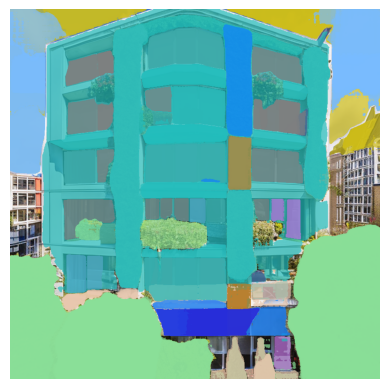

Annotated image saved to: /tmp/annotated_Large_city_house_in_Rotterdam_with_Aerial_Gardens._View_from_the_side,_full_view._highly_detailed,_8k,_64k,_HDR,_Flickr,_Hasselb-3413067435-DPM++ 2M Karras-30.png


In [8]:
# # Upload and process the image
uploaded_image_path = upload_image()
original_image = read_image(uploaded_image_path)
resized_and_cropped_image = resize_and_crop_image(original_image)

# Process the image and get the annotated version
#annotated_image, detections = process_image(resized_and_cropped_image, sam_predictor, grounding_dino_model, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD, NMS_THRESHOLD)
annotated_image, detections, masks = process_image(resized_and_cropped_image, sam_predictor, grounding_dino_model, CLASSES, BOX_THRESHOLD, TEXT_THRESHOLD, NMS_THRESHOLD)

# Show the annotated image
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save the annotated image to disk
output_image_path = f"/tmp/annotated_{uploaded_image_path}"
cv2.imwrite(output_image_path, annotated_image)
print(f"Annotated image saved to: {output_image_path}")


# Calculate and display areas and potential costs
# (You'll need to add your own logic to calculate areas and costs based on the detections)

In [9]:
# Function to calculate the physical scale from reference objects
def calculate_scale_from_reference(detections, masks, reference_label, reference_physical_height, CLASSES):
    reference_indices = [i for i, class_id in enumerate(detections.class_id) if CLASSES[class_id] == reference_label]
    reference_boxes = detections.xyxy[reference_indices]

    if len(reference_boxes) > 0:
        # Calculate the median height in pixels of the reference objects
        median_height_pixels = np.median([box[3] - box[1] for box in reference_boxes])  # y2 - y1 for each box
        # Calculate and return the physical scale as meters per pixel
        return reference_physical_height / median_height_pixels

    # If no reference objects found, return None
    return None

 # Function to calculate the area of each mask in square meters based on the physical scale
# Updated function to calculate areas and aggregate them by class
def calculate_mask_areas(masks, detections, scale, CLASSES):
    # Initialize dictionary to hold total area per class
    class_areas = {class_name: 0 for class_name in CLASSES}

    # Initialize list to hold areas for all masks
    areas_m2 = []

    # Calculate area for each mask and sum up areas by class
    for i, mask in enumerate(masks):
        area_m2 = np.sum(mask) * (scale ** 2)  # Convert pixel area to square meters
        areas_m2.append(area_m2)  # Append area of current mask to list
        class_name = CLASSES[detections.class_id[i]]  # Get the class name using class_id
        class_areas[class_name] += area_m2  # Add area to total for the class

    return class_areas, areas_m2

In [11]:
# Calculate scale using doors or windows

# Constants for reference object sizes (in meters)
DOOR_HEIGHT_M = 2.0   # Median height of doors in meters
WINDOW_HEIGHT_M = 1.20 # Median height of windows in meters


scale = calculate_scale_from_reference(detections, masks, "door", DOOR_HEIGHT_M, CLASSES)
if scale is None:  # If no doors, try windows
    scale = calculate_scale_from_reference(detections, masks, "window", WINDOW_HEIGHT_M, CLASSES)

# Example usage of the updated function after scale calculation
if scale is not None:
    class_areas, areas_m2 = calculate_mask_areas(masks, detections, scale, CLASSES)
    # Output the results
    for class_name, total_area in class_areas.items():
        if total_area > 0:  # Only print classes with non-zero total area
            print(f"Total area for {class_name}: {total_area:.2f} m²")
else:
    print("No reference object found for scale estimation. Area calculations will not be performed.")

Total area for brick: 8.67 m²
Total area for wood: 19.83 m²
Total area for concrete: 20.39 m²
Total area for metal: 2.14 m²
Total area for door: 12.98 m²
Total area for window: 136.70 m²
Total area for balcony: 293.51 m²
Total area for roof: 60.19 m²
Total area for street: 49.22 m²
Total area for sky: 71.13 m²
Total area for vegetation: 333.15 m²
